In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
data = pd.read_csv("insight-test.csv")

# Data Processing
## Overview of Data
We also want to ensure that NaN doesn't exist, they contain the same data counts and there is no missing data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229847 entries, 0 to 229846
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   user_id                 229847 non-null  int64  
 1   is_new                  229847 non-null  int64  
 2   time                    229847 non-null  object 
 3   voucher_type            38958 non-null   float64
 4   voucher_valid           41981 non-null   float64
 5   basket_amount           229847 non-null  float64
 6   voucher_max_amount      229847 non-null  float64
 7   voucher_percentage      229847 non-null  float64
 8   voucher_min_purchase    229847 non-null  float64
 9   voucher_amount          229847 non-null  float64
 10  trx_is_voucher          229847 non-null  int64  
 11  is_paid                 229847 non-null  int64  
 12  is_remitted             229847 non-null  int64  
 13  user_purchased_prior    229847 non-null  int64  
 14  num_voucher_errors  

## Handle Missing Vouchers
Since users without a valid vouchers are marked as 0, we will assume empty vouchers users doesn't hold any vouchers

In [4]:
data["voucher_type"].value_counts()

1.0    31969
0.0     6989
Name: voucher_type, dtype: int64

In [5]:
data["voucher_valid"].value_counts()

1.0    38958
0.0     3023
Name: voucher_valid, dtype: int64

In [6]:
data["voucher_type"] = data["voucher_type"].fillna(0)
data["voucher_valid"] = data["voucher_valid"].fillna(0)

### Handle Marketing Tier
We want to replace the `Tier_n to n`

We notice that the data is missing, since it is dangerous to assume anything. We will just remove it for now

In [7]:
data["marketing_tier"].value_counts()

tier_1    153695
tier_2     64509
tier_3     10688
tier_4       179
Name: marketing_tier, dtype: int64

In [8]:
data["marketing_tier"] = data["marketing_tier"].replace({
                                                    'tier_1': 1,
                                                    'tier_2': 2,
                                                    'tier_3': 3,
                                                    'tier_4': 4
                                                })

Remove the rows containing NaN values

In [9]:
data = data[data['marketing_tier'].notna()]

## Handle Time Data
We want to convert the string into readable datetime

In [10]:
data["time"] = pd.to_datetime(data["time"])
data["account_created_at"] = pd.to_datetime(data["account_created_at"])

As some visualisation are hard with timeseries, we will convert them into:

`time` : `time_month`, `time_day` # The transaction are all in 2015

`account_created_at` : `account_age` # In Days

In [11]:
data["time_month"] = data["time"].dt.month
data["time_day"] = data["time"].dt.day

data["account_age"] = (data["time"] - data["account_created_at"]).dt.days

## Drop Unused Columns


In [12]:
data = data.drop(columns=['time', 'account_created_at', 'user_id'])

# Data Visualisation
## Pearson Correlation of Features
The result ranges in -1 to 1: 1 shows a perfect correlation, 0 shows no correlation, -1 shows an opposite perfect correlation

In [13]:
corr_data = data.corr()

<AxesSubplot:>

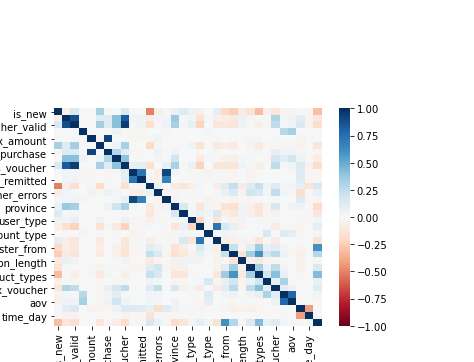

In [14]:
sns.heatmap(corr_data, cmap=plt.cm.RdBu, vmin=-1, vmax=1)

In [15]:
corr_data.style.background_gradient(cmap=plt.cm.RdBu, vmin=-1, vmax=1).set_precision(2)

,is_new,voucher_type,voucher_valid,basket_amount,voucher_max_amount,voucher_percentage,voucher_min_purchase,voucher_amount,trx_is_voucher,is_paid,is_remitted,user_purchased_prior,num_voucher_errors,purchase,province,marketing_tier,user_type,user_group,account_type,referrer_type,user_register_from,sessions,average_session_length,num_visit_promo_page,num_product_types,num_trx,num_trx_voucher,gmv,aov,time_month,time_day,account_age
is_new,1.00,-0.05,0.16,-0.01,-0.01,0.33,-0.01,0.00,0.16,0.01,0.00,-0.50,-0.07,0.02,0.07,0.13,0.06,-0.06,0.01,0.09,-0.20,-0.25,-0.08,-0.15,-0.31,-0.05,-0.12,-0.03,-0.03,0.02,-0.01,-0.30
voucher_type,-0.05,1.00,0.89,0.01,-0.00,0.13,0.14,0.42,0.84,0.03,0.04,-0.07,0.03,0.04,0.37,0.02,0.04,-0.15,0.01,-0.06,-0.07,-0.08,0.07,0.03,0.01,-0.01,0.30,0.03,0.06,0.11,-0.04,-0.10
voucher_valid,0.16,0.89,1.00,0.01,-0.00,0.34,0.13,0.42,0.95,0.03,0.04,-0.17,0.02,0.04,0.33,0.03,0.07,-0.22,0.00,-0.12,-0.11,-0.13,0.04,-0.00,-0.06,-0.02,0.25,0.02,0.05,0.16,-0.05,-0.17
basket_amount,-0.01,0.01,0.01,1.00,-0.00,-0.00,0.01,0.05,0.01,-0.01,-0.01,0.00,0.00,-0.01,0.01,-0.00,0.00,-0.00,0.04,-0.00,0.00,-0.00,0.00,0.01,0.00,-0.00,0.01,0.28,0.33,0.00,-0.00,0.00
voucher_max_amount,-0.01,-0.00,-0.00,-0.00,1.00,-0.00,0.93,0.01,-0.00,-0.02,-0.01,-0.01,0.04,-0.01,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.01,0.01,-0.00,0.02,0.02,0.00,0.01,0.00,0.00,-0.04,0.01,0.00
voucher_percentage,0.33,0.13,0.34,-0.00,-0.00,1.00,0.01,0.06,0.34,-0.00,0.00,-0.19,-0.01,0.01,-0.00,0.01,0.04,-0.14,-0.01,-0.10,-0.08,-0.09,0.01,-0.04,-0.10,-0.02,-0.02,-0.01,-0.01,-0.04,0.00,-0.12
voucher_min_purchase,-0.01,0.14,0.13,0.01,0.93,0.01,1.00,0.30,0.12,-0.02,-0.01,-0.01,0.06,-0.00,0.06,0.00,0.00,-0.02,0.00,-0.00,-0.01,-0.00,0.00,0.02,0.02,0.00,0.08,0.03,0.05,-0.02,0.02,-0.02
voucher_amount,0.00,0.42,0.42,0.05,0.01,0.06,0.30,1.00,0.40,-0.00,0.01,-0.01,0.02,0.02,0.20,0.00,0.01,-0.09,0.02,-0.01,-0.05,-0.06,0.02,0.02,0.00,-0.01,0.19,0.11,0.19,0.05,-0.01,-0.08
trx_is_voucher,0.16,0.84,0.95,0.01,-0.00,0.34,0.12,0.40,1.00,0.09,0.09,-0.16,0.01,0.08,0.32,0.02,0.07,-0.23,0.00,-0.12,-0.11,-0.13,0.04,-0.01,-0.06,-0.02,0.25,0.02,0.04,0.15,-0.04,-0.17
is_paid,0.01,0.03,0.03,-0.01,-0.02,-0.00,-0.02,-0.00,0.09,1.00,0.74,0.01,-0.07,0.91,0.03,0.00,-0.01,0.02,-0.03,0.02,-0.01,-0.03,-0.00,-0.03,-0.00,0.00,-0.00,0.00,-0.00,0.13,-0.02,-0.01


In [16]:
# sns.pairplot(data.sample(n = 100))

# Data Exploration
## `is_new`
A potential success for any e-commerce platform is the large and growing number of user

In [17]:
corr_data['is_new'].sort_values()

user_purchased_prior     -0.503403
num_product_types        -0.309826
account_age              -0.301380
sessions                 -0.247502
user_register_from       -0.200251
num_visit_promo_page     -0.146333
num_trx_voucher          -0.122178
average_session_length   -0.080536
num_voucher_errors       -0.065058
user_group               -0.055309
voucher_type             -0.052824
num_trx                  -0.047010
aov                      -0.034818
gmv                      -0.031869
voucher_min_purchase     -0.012990
time_day                 -0.010209
voucher_max_amount       -0.007221
basket_amount            -0.007118
voucher_amount            0.001292
is_remitted               0.001705
account_type              0.005679
is_paid                   0.013374
time_month                0.015476
purchase                  0.021187
user_type                 0.059471
province                  0.067212
referrer_type             0.094068
marketing_tier            0.131109
trx_is_voucher      

Picking the top ones are:

- Voucher percentage (Likely to be voucher discounts)
- Voucher is valid
- Paid using the said voucher
- Marketing tier

The bottom ones are: (Opposite colleration, lower = new user)

(Good context) tells us which feature will bring new user
- Have the user purchased before
- User registered from

(Out of the context) we want to know which will attract new user, not which are the new user)
- Number of product types (Vague?)
- Account age
- Sessions

### Voucher Percentage

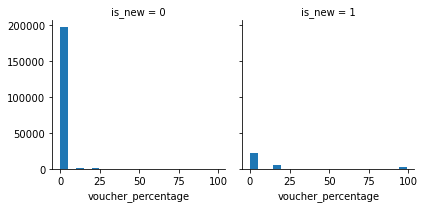

In [151]:
g = sns.FacetGrid(data, col='is_new')
g.map(plt.hist, 'voucher_percentage', bins=20)

Poor visualisation, 0 is included, let's remove that

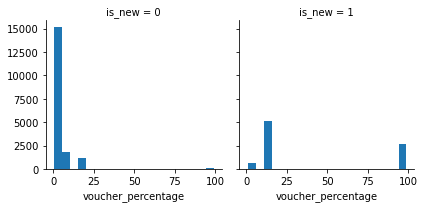

In [153]:
g = sns.FacetGrid(data.loc[data['voucher_percentage'] > 0], col='is_new')
g.map(plt.hist, 'voucher_percentage', bins=20)

We can see that new user who come in using vouchers are more likely to use 10-15% discount vouchers, followed by 95-100% vouchers.

However, this argument can be countered as when a user purchase for the first time, they will get a vouchers.

### Voucher Valid

In [38]:
data[["voucher_valid", "is_new"]].groupby(['voucher_valid'], as_index=False).mean().sort_values(by='is_new', ascending=False)

,voucher_valid,is_new
1,1.0,0.247337
0,0.0,0.105315


New User are more likely to have a valid voucher

In [36]:
data[["trx_is_voucher", "is_new"]].groupby(['trx_is_voucher'], as_index=False).mean().sort_values(by='is_new', ascending=False)

,trx_is_voucher,is_new
1,1,0.249883
0,0,0.106823


## Marketing Tier

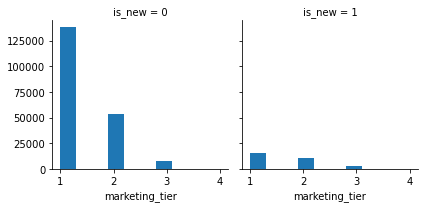

In [156]:
g = sns.FacetGrid(data, col='is_new')
g.map(plt.hist, 'marketing_tier')

<AxesSubplot:xlabel='is_new', ylabel='marketing_tier'>

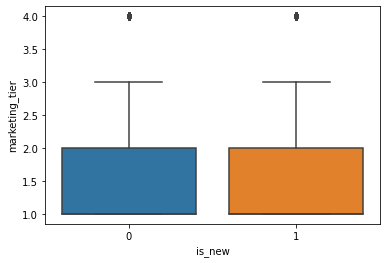

In [22]:
sns.boxplot(data = data, x = data["is_new"], y = data["marketing_tier"])

In [97]:
data[["is_new", "marketing_tier"]].groupby(['is_new'], as_index=False).mean().sort_values(by='marketing_tier', ascending=False)

,is_new,marketing_tier
1,1,1.573486
0,0,1.348104


They follow similar distribution, thefore we cannot infer anythiong from it

## `is_paid`
A potential success for any e-commerce platform is the amount of success full transactions

In [39]:
corr_data['is_paid'].sort_values()

num_voucher_errors       -0.071239
num_visit_promo_page     -0.032808
account_type             -0.032356
sessions                 -0.026598
time_day                 -0.020590
voucher_max_amount       -0.018824
voucher_min_purchase     -0.017277
user_type                -0.013567
user_register_from       -0.013382
basket_amount            -0.012823
account_age              -0.011344
num_product_types        -0.004893
average_session_length   -0.004559
num_trx_voucher          -0.002499
voucher_percentage       -0.002424
voucher_amount           -0.002137
aov                      -0.000038
gmv                       0.001974
marketing_tier            0.003107
num_trx                   0.003733
is_new                    0.013374
user_purchased_prior      0.014285
user_group                0.015988
referrer_type             0.020584
voucher_valid             0.029249
province                  0.030300
voucher_type              0.032924
trx_is_voucher            0.086167
time_month          

It is a bit hard to infer anything from here. `purchase` and `is_remitted` are data connected to `is_paid`

## `gmv` Gross Merchandise Value
Despite the number of customer. An income for any e-commerce platform is always measured by the value of the item ordered. A higher value will generate revenue due to the commision system

We Choose GMV over AOV (Average Order Value) due to the fact that GMV accounts for number of item in one transactions, where AOV averages that value.

In [23]:
corr_data['gmv'].sort_values()

is_new                   -0.031869
voucher_percentage       -0.010695
average_session_length   -0.004595
time_month               -0.003458
user_group               -0.003318
user_type                -0.002000
time_day                 -0.000362
marketing_tier            0.000021
voucher_max_amount        0.000950
referrer_type             0.001620
is_paid                   0.001974
is_remitted               0.005857
province                  0.005971
purchase                  0.006087
trx_is_voucher            0.016104
voucher_valid             0.017273
voucher_type              0.025879
num_voucher_errors        0.031864
voucher_min_purchase      0.031887
account_age               0.032303
user_purchased_prior      0.034864
user_register_from        0.035414
num_visit_promo_page      0.043653
sessions                  0.054864
num_product_types         0.075851
num_trx_voucher           0.102495
voucher_amount            0.112186
account_type              0.126875
basket_amount       

In [24]:
# ax = sns.kdeplot(data = data.sample(200), x = data["gmv"], y = data["num_trx"])
# plt.show()

# ML Model

With all these data, why not create a model that predict future user if they might be a buyer in the future

It also doubles to check which feature is the most important

In [92]:
import eli5

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor

In [42]:
train_data, test_data = train_test_split(data, test_size=0.1)
# Train data for is_new, is_paid and gmv respectively
isNew_X_train = train_data.drop(columns=['is_new'])
isNew_Y_train = train_data['is_new']
isPaid_X_train = train_data.drop(columns=['is_paid'])
isPaid_Y_train = train_data['is_paid']
isPaid_Unconnected_X_train = train_data.drop(columns=['is_paid', 'is_remitted', 'purchase'])
isPaid_Unconnected_Y_train = train_data['is_paid']
gmv_X_train = train_data.drop(columns=['gmv'])
gmv_Y_train = train_data['gmv']
# Test data for is_new, is_paid and gmv respectively
isNew_X_test = test_data.drop(columns=['is_new'])
isNew_Y_test = test_data['is_new']
isPaid_X_test = test_data.drop(columns=['is_paid'])
isPaid_Y_test = test_data['is_paid']
isPaid_Unconnected_X_test = test_data.drop(columns=['is_paid', 'is_remitted', 'purchase'])
isPaid_Unconnected_Y_test = test_data['is_paid']
gmv_X_test = test_data.drop(columns=['gmv'])
gmv_Y_test = test_data['gmv']
# Shuffle Each
isNew_X_train, isNew_Y_train = shuffle(isNew_X_train, isNew_Y_train, random_state=0)
isPaid_X_train, isPaid_Y_train = shuffle(isPaid_X_train, isPaid_Y_train, random_state=0)
isPaid_Unconnected_X_train, isPaid_Unconnected_Y_train = shuffle(isPaid_Unconnected_X_train, isPaid_Unconnected_Y_train, random_state=0)
gmv_X_train, gmv_Y_train = shuffle(gmv_X_train, gmv_Y_train, random_state=0)

### Standarise And Normalise

In [103]:
# Max, Min, Mean, Std
gmv_max = gmv_X_train.max(axis=0)
gmv_min = gmv_X_train.min(axis=0)
gmv_mean = gmv_X_train.mean(axis=0)
gmv_std = gmv_X_train.std(axis=0)
# Normalise (feature Scaling) for Regression
gmv_X_train_FS = (gmv_X_train - gmv_min) / (gmv_max - gmv_min)
gmv_X_test_FS = (gmv_X_test - gmv_min) / (gmv_max - gmv_min)
# Standarise for Regression
gmv_X_train_std = (gmv_X_train - gmv_mean) / gmv_std
gmv_X_test_std = (gmv_X_test - gmv_mean) / gmv_std

In [104]:
# Max, Min, Mean, Std
gmv_max = gmv_Y_train.max()
gmv_min = gmv_Y_train.min()
gmv_mean = gmv_Y_train.mean()
gmv_std = gmv_Y_train.std()
# Normalise (feature Scaling) for Regression
gmv_Y_train_FS = (gmv_Y_train - gmv_min) / (gmv_max - gmv_min)
gmv_Y_test_FS = (gmv_Y_test - gmv_min) / (gmv_max - gmv_min)
# Standarise for Regression
gmv_Y_train_std = (gmv_Y_train - gmv_mean) / gmv_std
gmv_Y_test_std = (gmv_Y_test - gmv_mean) / gmv_std

## Simple - Logistic Regression
### `is_new`

In [27]:
isNew_LR_model = LogisticRegressionCV(random_state=0, max_iter=500, n_jobs=-1, cv=5).fit(isNew_X_train, isNew_Y_train)

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9525056748734066

In [85]:
print("Logistric Regression Percentage Correct: {}".format(isNew_LR_model.score(isNew_X_test, isNew_Y_test)))

Logistric Regression Percentage Correct: 0.9489261393399686


In [29]:
eli5.show_weights(isNew_LR_model, feature_names=isNew_X_train.columns.values)

We can see that:

(Higher Chance)
- we will bring in new user if the voucher is valid.
- A higher account type would be a new user?

(Lower Chance)
- New user are more likey to purchase
- And purchase with a voucher

(Irrelevant, But good observation)
- New user are unlikely to stay and browse around the shop
- They are also unlikely to visit promo page
- New user are unlikely to order a more expensive stuff
- New user are more wiling to complete their transaction

### `is_paid`

In [43]:
isPaid_LR_model = LogisticRegressionCV(random_state=0, max_iter=500, n_jobs=-1, cv=5).fit(isPaid_X_train, isPaid_Y_train)

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [84]:
print("Logistric Regression Percentage Correct: {}".format(isPaid_LR_model.score(isPaid_X_train, isPaid_Y_train)))

Logistric Regression Percentage Correct: 0.9951300669858316


In [50]:
eli5.show_weights(isPaid_LR_model, feature_names=isPaid_X_train.columns.values)

Expected result here, we can't really infer anything interesting.

Inferring user who paid are likely to purchase is like saying water is wet.

### `is_paid_Unconnected`

In [45]:
isPaid_Unconnected_LR_model = LogisticRegressionCV(random_state=0, max_iter=500, n_jobs=-1, cv=5).fit(isPaid_Unconnected_X_train, isPaid_Unconnected_Y_train)

In [83]:
print("Logistric Regression Percentage Correct: {}".format(isPaid_Unconnected_LR_model.score(isPaid_Unconnected_X_test, isPaid_Unconnected_Y_test)))

Logistric Regression Percentage Correct: 0.9605814562598219


In [51]:
eli5.show_weights(isPaid_Unconnected_LR_model, feature_names=isPaid_Unconnected_X_train.columns.values)

Much better information compared to "connected" data.

We can see that:

(Higher Chance)
- User are more willing to pay if they can use a voucher
- Voucher type also affect this decision

(Lower Chance)
- A certain time of month, user are more willing to pay
- The more product type it has (user viewed or product category?), the more willing the user are paying
- New user are willing to pay

(Irrelevant, But good observation)
- User will unlikely to pay if the voucher are invalid
- High session doesn't indicate that users are willing to pay
- Visiting promo page also doesn't indicate that users are willing to pay
- High voucher amount also doesn't indicate that users are willing to pay
- Voucher limitations also doesn't indicate that users are willing to pay
- Lower account type shows lower purchase chance

## Simple - Linear Regression
### `gmv` Gross Mercenadise Value

In [135]:
def KFold_trainer(
    X,
    Y,
    model,
    n_splits = 5
):
    kf = KFold(n_splits=n_splits)

    temp_model_array = []
    temp_model_array_metric = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        temp_model = model
        temp_model.fit(X_train, y_train)
        temp_model_array_metric.append(temp_model.score(X_test, y_test))
        temp_model_array.append(temp_model)

    print("Best Validation R-squared Score: {}".format(max(temp_model_array_metric)))
    return temp_model_array[temp_model_array_metric.index(max(temp_model_array_metric))]

In [136]:
X = [gmv_X_train, gmv_X_train_FS, gmv_X_train_std]
Y = [gmv_Y_train, gmv_Y_train_FS, gmv_Y_train_std]
gmv_LR_model = []

for i in range(len(X)):
    temp_model = LinearRegression(n_jobs=-1)
    gmv_LR_model.append(KFold_trainer(X[i], Y[i], temp_model))

Best Validation R-squared Score: 0.7977500117389213
Best Validation R-squared Score: 0.7977500117389211
Best Validation R-squared Score: 0.7977500117389204


No Difference between raw, feature scaled and standarised data

Therefore, we will just pick the raw data model

In [137]:
gmv_LR_model = gmv_LR_model[0]
gmv_Y_test_pred = gmv_LR_model.predict(gmv_X_test)
print("Linear Regression Test R-squared Score: {}".format(gmv_LR_model.score(gmv_X_test, gmv_Y_test)))
print("Linear Regression Test RMSE: {}".format(mean_squared_error(gmv_Y_test, gmv_Y_test_pred)))
print("Linear Regression Test MAE: {}".format(mean_absolute_percentage_error(gmv_Y_test, gmv_Y_test_pred)))

Linear Regression Test R-squared Score: 0.66712917445017
Linear Regression Test RMSE: 1.727508631663899e-05
Linear Regression Test MAE: 0.011512470986003663


In [138]:
eli5.show_weights(gmv_LR_model, feature_names=gmv_X_train.columns.values)

Weight?,Feature
+0.936,num_trx
+0.492,aov
+0.050,basket_amount
+0.011,num_trx_voucher
+0.004,voucher_min_purchase
+0.002,num_visit_promo_page
+0.001,num_product_types
+0.000,is_new
+0.000,voucher_valid
+0.000,is_paid


We can see that:

- User who have a high amount of transaction (Lifetime Total or This basket only?) are more willing to spend more
- User who buy more expensive item are more willing to spend more (Obvious, but quantily > qantity)

## Simple - Decision Tree
### `gmv` Gross Mercenadise Value

In [139]:
X = [gmv_X_train, gmv_X_train_FS, gmv_X_train_std]
Y = [gmv_Y_train, gmv_Y_train_FS, gmv_Y_train_std]
gmv_DT_model = []

for i in range(len(X)):
    temp_model = DecisionTreeRegressor()
    gmv_DT_model.append(KFold_trainer(X[i], Y[i], temp_model))

Best Validation R-squared Score: 0.9988609551654054
Best Validation R-squared Score: 0.999651779907784
Best Validation R-squared Score: 0.9995961446612235


Feature Scaling > Standarisation > Raw Data

Therefore, we will pick the feature scaled data model

In [140]:
gmv_DT_model = gmv_DT_model[1]
gmv_Y_test_pred = gmv_DT_model.predict(gmv_X_test_FS)
print("Linear Regression Test R-squared Score: {}".format(gmv_DT_model.score(gmv_X_test_FS, gmv_Y_test_FS)))
print("Linear Regression Test RMSE: {}".format(mean_squared_error(gmv_Y_test_FS, gmv_Y_test_pred)))
print("Linear Regression Test MAE: {}".format(mean_absolute_percentage_error(gmv_Y_test_FS, gmv_Y_test_pred)))

Linear Regression Test R-squared Score: 0.9965742369364284
Linear Regression Test RMSE: 1.7778774251483117e-07
Linear Regression Test MAE: 0.00021207968042501684


In [144]:
eli5.show_weights(gmv_DT_model, feature_names=gmv_X_train_FS.columns.values, show=['targets', 'feature_importances'])

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\eli5\sklearn\treeinspect.py:64: RuntimeWarning: invalid value encountered in true_divide
  value_ratio=list(value / value.sum()),


Weight,Feature
0.6658,aov
0.3286,num_trx
0.0029,province
0.0011,num_visit_promo_page
0.0003,num_trx_voucher
0.0003,account_age
0.0002,user_type
0.0001,average_session_length
0.0001,voucher_percentage
0.0001,referrer_type


We see the same feature importance like linear regression, but `aov` and `num_trx` are flipped

We can see that:

- User who have a high amount of transaction (Lifetime Total or This basket only?) are more willing to spend more
- User who buy more expensive item are more willing to spend more (Obvious, but quantily > qantity)

Future Findings that might affect gross merchandise value:

- Province